In [1]:
import glob
import os
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque

import re

from datetime import datetime
from datetime import timedelta
from datetime import date

In [2]:
%matplotlib inline

## Load Data

In [3]:
# make a variable with a root directory path
# then have relative path

In [4]:
#This assumes results are 1 level down from root directory

data_directory = '/home/kel2158/Projects/COVIDHerit/data/'
results_directory = '/home/kel2158/Projects/COVIDHerit/results/12_29_21'

revision_results_directory = '/home/kel2158/Projects/COVIDHerit/results/revisions_7_23'

#NYC wide hospitalizations and case data from https://www1.nyc.gov/site/doh/covid/covid-19-data-totals.page

nyc_covid_hosp_file = data_directory + 'hosp-by-day.csv'
nyc_covid_cases_file = data_directory + 'cases-by-day.csv'
fam_size_file = data_directory +'/12_29_21/fam_size.txt'


In [5]:
fam_size_df = pd.read_csv(fam_size_file,sep=" ")

pheno2sampsize = dict(zip( fam_size_df["pheno"],fam_size_df["famcount"] ))

In [6]:
#Process Data
def create_solar_df(h2_results, header):
    '''function that takes in results as deque and turns them as a dataframe'''

    header.extend(["file","directory"])
    df = pd.DataFrame(results,columns=header)
    
    #Turn into floats and ints from strings
    for col in ['estimate', 'estimate_lower','estimate_upper', 'solarerr', 'solarpval','posa']:
        df[col].update( df[col].astype(float) )


    df["num_families"].update( df["num_families"].astype(int))


    clean_model_name = {"ACE_h2o":"Heritability","ACE_Shared_Env":"Shared Environment",
                       "AE":"AE"}
   
    df["model_clean"] = df["model"].map(clean_model_name)
    

    return(df)

In [7]:
def process_file(file_path, results, incomplete_rows, header):
    '''Function that takes in a file path, already pulled results 
    and incomplete results and a header if we have it and returns 
    concatenated resultsin the form of a deque'''   
    
    with open(file_path) as f:
        reader = csv.reader(f, delimiter='\t')
        
        try:
            header = next(reader)[0].split(",")
            for row in reader:
                row_split = row[0].split(",")
                file_name = os.path.basename(file_path)
                directory_name = os.path.basename(os.path.dirname(file_path))
                
                row_split.append(file_name)
                row_split.append(directory_name)

                if len(row_split) == 15:
                    results.append(tuple(row_split))
                else:
                    incomplete_rows.append(tuple(row_split))


        except StopIteration:
            # Handle the case when there are no rows in the CSV file
            pass
        
    return results, incomplete_rows, header



In [8]:
#Load all cov data

results = deque()
incomplete_rows = deque()
header = None

# Process file paths matching pattern */*/*results.csv
for file_path in glob.glob(f'{results_directory}/*/*/*results.csv', recursive=True):
    results, incomplete_rows, header = process_file(file_path, results, incomplete_rows, header)

# Process file paths matching pattern */*results.csv
for file_path in glob.glob(f'{results_directory}/*/*results.csv', recursive=True):
    results, incomplete_rows, header = process_file(file_path,results, incomplete_rows, header)

solar_df = create_solar_df(results, header)
print(len( incomplete_rows ) )

0


In [9]:
#Load no sex or age data

results = deque()
incomplete_rows = deque()
header = None

# # Process file paths matching pattern */*/*results.csv
# for file_path in glob.glob(f'{revision_results_directory}/*/*/*results.csv', recursive=True):
#     results, incomplete_rows, header = process_file(file_path, results, incomplete_rows, header)

# Process file paths matching pattern */*results.csv
for file_path in glob.glob(f'{revision_results_directory}/*/*results.csv', recursive=True):
    results, incomplete_rows, header = process_file(file_path,results, incomplete_rows, header)

solar_rev_df = create_solar_df(results, header)

## NYC Data

In [10]:
file = nyc_covid_cases_file
nyc_case_df = pd.read_csv(file)

file = nyc_covid_hosp_file
nyc_df = pd.read_csv(file)

In [11]:
#get in datetime
pull_date_from_nycases = lambda date: datetime.strptime(date, '%m/%d/%Y' ).date()

nyc_df["date_cln"] = nyc_df["date_of_interest"].apply(pull_date_from_nycases)
nyc_case_df["date_cln"] = nyc_case_df["date_of_interest"].apply(pull_date_from_nycases)

In [12]:
#Get the weeks
pull_date_from_trait = lambda trait: datetime.strptime(trait.replace("covid_cswitch_weekly_",""), '%m_%d_%Y' ).date()

weeks = list( set( solar_df[ solar_df["trait"].str.contains("covid_cswitch_weekly_") ]\
                  ["trait"].apply(pull_date_from_trait) ))

weeks.sort()

## Graphing Functions

In [13]:
plt.rc("axes.spines", top=False, right=False)

In [14]:
regex = r'(\d+_\d+_\d+)'

pull_date = lambda trait_name: datetime.strptime(re.findall(regex, trait_name)[0]\
                                                 ,'%Y-%m-%d').date()

pull_date_window = lambda trait_name: datetime.strptime(re.findall(regex, trait_name)[0]\
                                                 ,'%m_%d_%Y').date()

In [15]:
#Function to map the colors as a list from the input list of x variables
def pltcolor(posas):
    cols = []
    for posa in posas:
        if posa < 0.2:
            cols.append('red')
        elif posa < 0.8:
            cols.append('orange')
        else:
            cols.append('green')
    return cols

In [16]:
import numpy as np

def pull_graph_vals(df, model, x):
    model_data = df[df["model_clean"] == model]
    
    lower_err = model_data["estimate"] - model_data["estimate_lower"]
    upper_err = model_data["estimate_upper"] - model_data["estimate"]
    err = [lower_err, upper_err]
    
    x_values = model_data[x]
    y_values = model_data["estimate"]
    
    posa_color = pltcolor(model_data["posa"])
    
    num_fams = model_data["num_families"].astype(int).values
    
    return err, x_values, y_values, posa_color, num_fams

In [17]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for num, rect in enumerate(rects):
        height = rect.get_height()

        # If there are a whole bunch of labels, only include every fifth
        if len(rects) >= 12 and num % 5 != 0:
            continue

        ax.text(rect.get_x() + rect.get_width() / 2., 1.05 * height,
                '%d' % int(height),
                ha='center', va='bottom')

In [18]:
def create_graph(df, x_value_col, plot_title, model_type="ace", hide_error=False, use_fam=True, remove_scatter_markers=False):
    """Takes in dataframes for a specific trait and graphs it"""
    
    if use_fam:
        fig, axs = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]})
        ax1 = axs[0]
        ax2 = axs[1]
        fig.set_size_inches(9, 6)
    else:
        fig, axs = plt.subplots(nrows=1, ncols=1)
        ax1 = axs
        fig.set_size_inches(9, 4.5)

    

    
    if model_type == "ace":
        model_lst = ['Heritability', 'Shared Environment']
    
    elif model_type == "ae":
        model_lst = ['AE']
    
    else:
        model_type == "all"
        model_lst = ['Heritability', 'Shared Environment', 'AE']
    
    num_fams_lst = []
    
    for model in model_lst:
        err, x, y, posa_color, num_fams = pull_graph_vals(df, model, x_value_col)
        
        if remove_scatter_markers:
            p1 = ax1.scatter(x=x, y=y, c=posa_color, s=0.001)
        else:
            p1 = ax1.scatter(x=x, y=y, c=posa_color)
        
        ax1.set_ylabel("Estimate")
        
        if hide_error:
            ax1.errorbar(x, y, linestyle='--', elinewidth=0.4, label=model)
        else:
            p2 = ax1.errorbar(x, y, yerr=err, linestyle='--', elinewidth=0.4, label=model)
            ax1.set_ylim([0, 1])
        
        ax1.legend(frameon=False)
        
        num_fams_lst.extend(list(zip(x, num_fams)))
    
    bar_width = 0.09 if x_value_col != "date" else 5
        
    
    fam_df = pd.DataFrame(num_fams_lst, columns=[x_value_col, "num_fams"]).sort_values(by=x_value_col)
    fam_df.drop_duplicates(inplace=True)
    
    if use_fam:
        rec = ax2.bar(fam_df[x_value_col], fam_df["num_fams"], width=bar_width, color="white", edgecolor='grey')
        ax2.set_ylabel("Number of Families")
        ax2.set_xlabel("Percent Families Included" if x_value_col != "date" else "Date Cutoff")
        autolabel(rec, ax2)

    fig.suptitle(plot_title)
    plt.show()
    sns.despine(fig)
    
   
    
    return fig, axs

## All Cov Graphs

In [19]:
clean_pheno_titles = {'covid':"SARS-CoV-2 Susceptibility",
 'covid_noproband':"SARS-CoV-2  Susceptibility, No Proband Requirement",
 'days_hosp':"Days Hospitalized",
 'hosp_stat':"Hospitalization Status",
 'hosp_stat_nopro':'Hospitalization Status, No Proband Requirement',
 'covid_highdeg_fam':'SARS-CoV-2  Susceptibility, High Degree Families',
 'covid_highdeg_nopro':'SARS-CoV-2 Susceptibility, High Degree Families, No Proband Requirement',
 'dayshosp_noage' : 'Days Hospitalized, No Age Covariate',
 'dayshosp_nosex': 'Days Hospitalized, No Sex Covariate',
 'dayshosp_nosex_noage': 'Days Hospitalized, No Sex Or Age Covariates',
 'covid_noage': 'SARS-CoV-2  Susceptibility, No Age Covariate',
 'covid_nosex': 'SARS-CoV-2  Susceptibility, No Sex Covariate',
 'covid_nosex_noage': 'SARS-CoV-2  Susceptibility, No Sex or Age Covariate'      
                     }

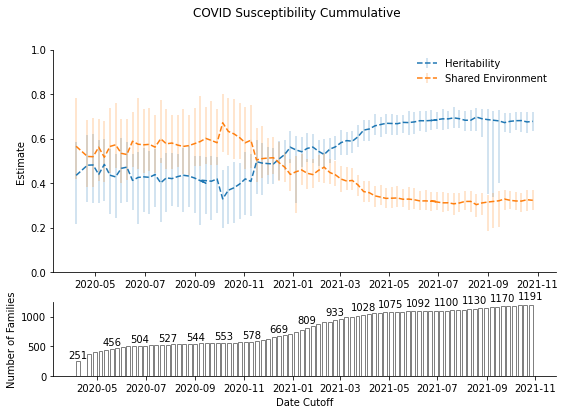

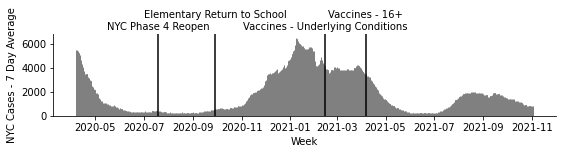

In [20]:
#Minimimum of 50 converged runs

#Partition by phenotype
df_holder = solar_df[ ( solar_df["trait"].str.contains( "covid_cswitch_weekly" ) == True ) &
                        ( solar_df["directory"] == "cummulative_classswitch")
                        ].copy()


df_holder = df_holder[ df_holder["num_converged"].astype(int) > 50 ]


#Pull date cases/controls are included through from phenotype name
df_holder["date"] = df_holder["trait"].apply( pull_date_window )

#sort by the number of families 
df_holder.sort_values(by="num_families",inplace=True)

#get graph
fig = create_graph(df_holder,"date","COVID Susceptibility Cummulative", remove_scatter_markers = True)


#Used in manuscript
fig, axs= plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(9, 1.5)

x = nyc_case_df[ (nyc_case_df["date_cln"] >= weeks[0]) &
                        (nyc_case_df["date_cln"] <= weeks[-1] + timedelta(days=7))
                        ]["date_cln"]

y = nyc_case_df[ (nyc_case_df["date_cln"] >= weeks[0]) &
                        (nyc_case_df["date_cln"] <= weeks[-1] + timedelta(days=7))
                        ]["ALL_CASE_COUNT_7DAY_AVG"]


adm_plt = axs.bar(x,y, width=0.1, color="white",edgecolor='grey')


axs.set_xlabel("Week")
axs.set_ylabel("NYC Cases - 7 Day Average")


sns.despine()

#Phase 4 repopen July 19th, 2020
plt.axvline(x = datetime(2020, 7, 19).date(), color = 'black', label = 'NYC Phase 4 Reopen')
plt.text(datetime(2020, 7, 19).date(), max(y)+ 500, 'NYC Phase 4 Reopen', ha='center', va='bottom')

#Elementary kids return to school September 29, 2020
plt.axvline(x = datetime(2020, 9, 29).date(), color = 'black', label = 'Elementary Return to School')
plt.text(datetime(2020, 9, 29).date(), max(y)+ 1500, 'Elementary Return to School', ha='center', va='bottom')



plt.axvline(x=datetime(2021, 2, 14).date(), color='black')
plt.text(datetime(2021, 2, 14).date(), max(y)+ 500, 'Vaccines - Underlying Conditions', ha='center', va='bottom')

plt.axvline(x=datetime(2021, 4, 6).date(), color='black')
plt.text(datetime(2021, 4, 6).date(), max(y)+ 1500, 'Vaccines - 16+', ha='center', va='bottom')

plt.show()





In [21]:
#Get lsit of all phenotypes in results
phenos_lst = solar_df["trait"].unique()

#Finds phenos in df that contains these words (really groupings of phenos)

phenos = ["covid","covid_noproband","days_hosp","hosp_stat","hosp_stat_nopro",\
                   "covid_highdeg_fam","covid_highdeg_nopro"
                   
                  ]


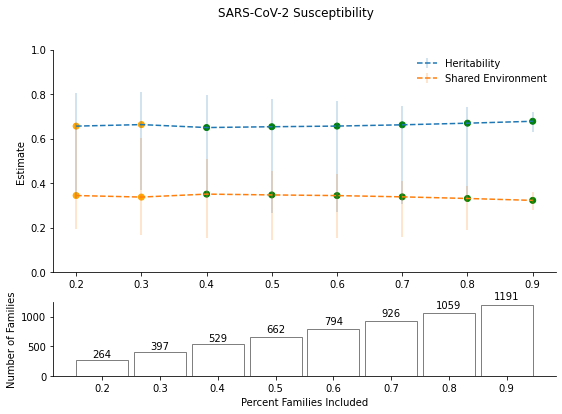

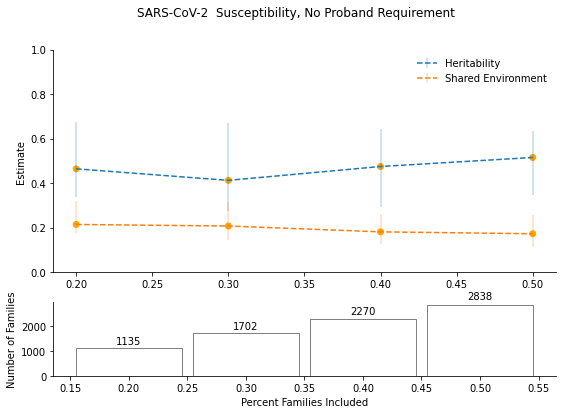

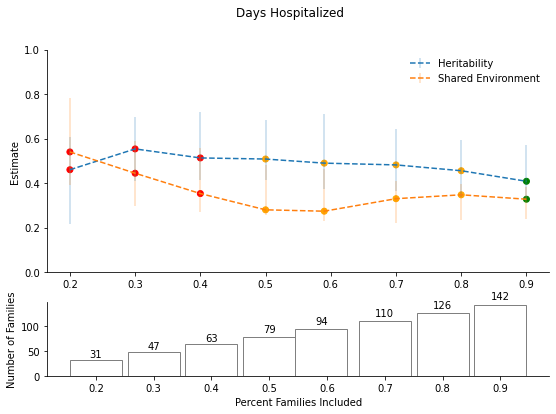

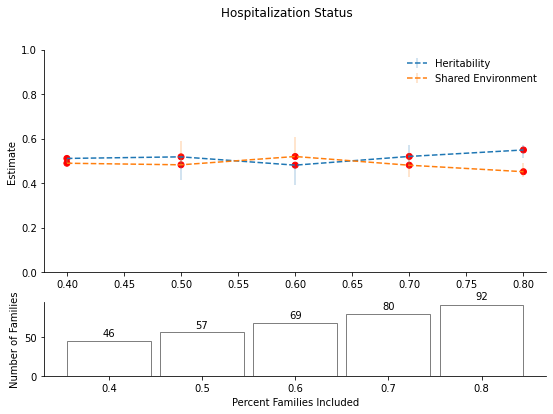

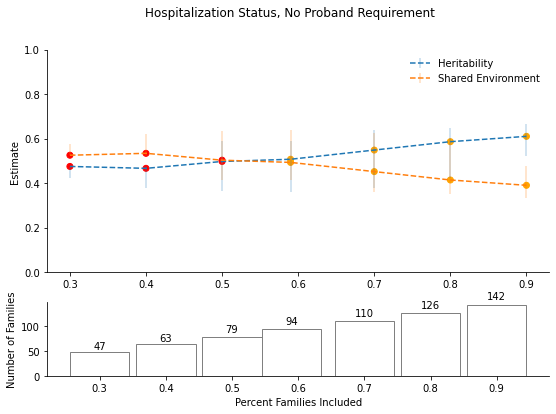

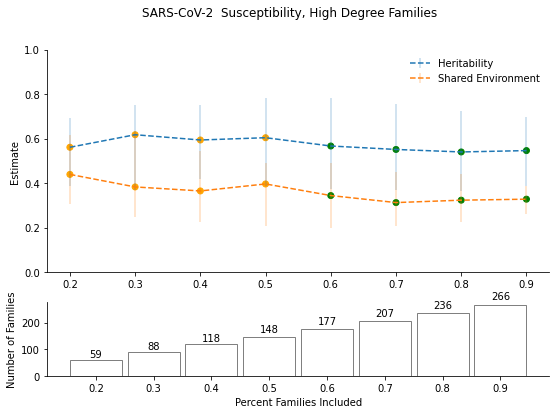

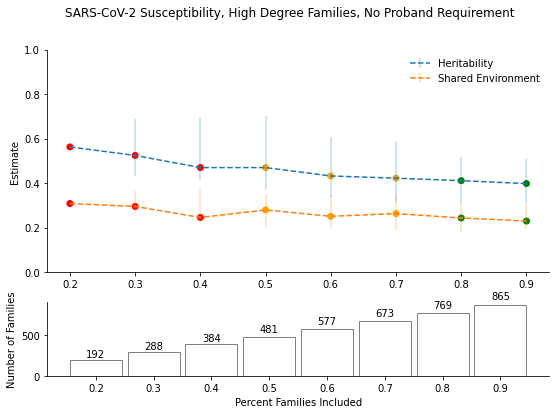

In [22]:
for pheno in phenos:
    
    #Partition by phenotype
    df_holder = solar_df[ solar_df["trait"] == pheno ].copy()
    
    #Assumes includes max 90% families for SOLARSTRAP
    num_total_fams = pheno2sampsize[pheno]
        

    #Calc percent fams included per solar iteration
    df_holder["fam_percent"] = df_holder["num_families"]/num_total_fams
    df_holder["fam_percent"].update( df_holder["fam_percent"].apply(round,ndigits=2) )
    
    
    #sort by the number of families 
    df_holder.sort_values(by="num_families",inplace=True)
    
    #get graph
    fig,axs = create_graph(df_holder,"fam_percent",clean_pheno_titles[pheno])


In [23]:
def graph_percent_fam(df, pheno, directory ):
    #Partition by phenotype
    df_holder = df[ ( df["directory"] == directory )&\
                  ( df["trait"] == pheno )].copy()
    
    #Assumes includes max 90% families for SOLARSTRAP
    num_total_fams = pheno2sampsize[pheno]
        
    clean_name = clean_pheno_titles[directory]
    
    #Calc percent fams included per solar iteration
    df_holder["fam_percent"] = df_holder["num_families"]/num_total_fams
    df_holder["fam_percent"].update( df_holder["fam_percent"].apply(round,ndigits=2) )
    
    
    #sort by the number of families 
    df_holder.sort_values(by="num_families",inplace=True)
    
    #get graph
    fig,axs = create_graph(df_holder,"fam_percent",clean_name)
    

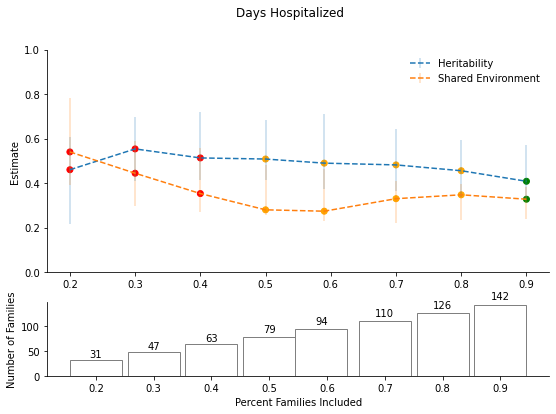

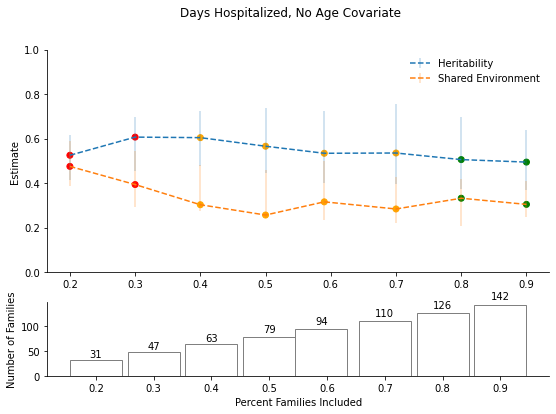

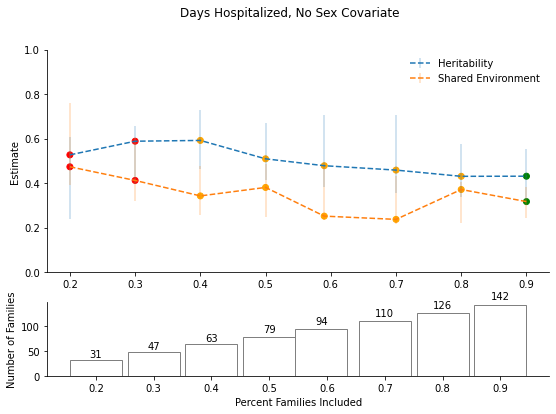

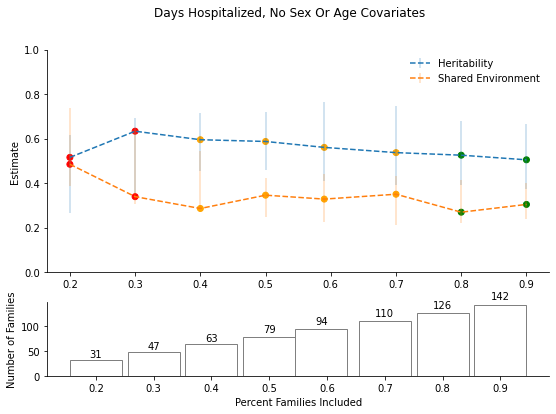

In [24]:
#Graph days hospitalized
graph_percent_fam(solar_df, "days_hosp", "days_hosp")
graph_percent_fam(solar_rev_df, "days_hosp", "dayshosp_noage")
graph_percent_fam(solar_rev_df, "days_hosp", "dayshosp_nosex")
graph_percent_fam(solar_rev_df, "days_hosp", "dayshosp_nosex_noage")
# graph_percent_fam(solar_rev_df, "days_hosp", "dayshosp_female")
# graph_percent_fam(solar_rev_df, "days_hosp", "dayshosp_notfemale")

In [25]:
solar_rev_df["directory"].unique()

array(['covid_nosex', 'dayshosp_notfemale', 'covid_female',
       'dayshosp_nosex', 'covid_nosex_noage',
       'cummulative_classswitch_noage', 'cummulative_classswitch_nosex',
       'covid_noage', 'covid_noproband_female', 'dayshosp_noage',
       'dayshosp_nosex_noage', 'cummulative_classswitch_nosex_noage',
       'dayshosp_female', 'covid_notfemale'], dtype=object)

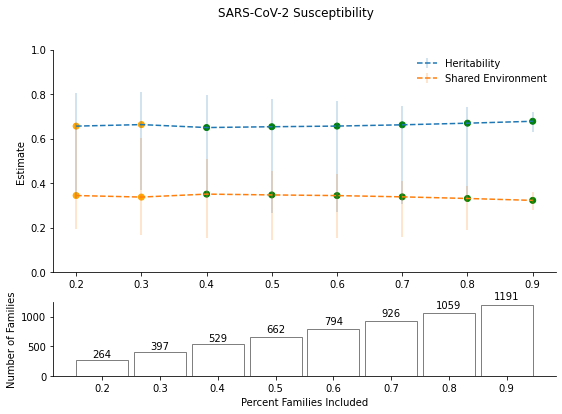

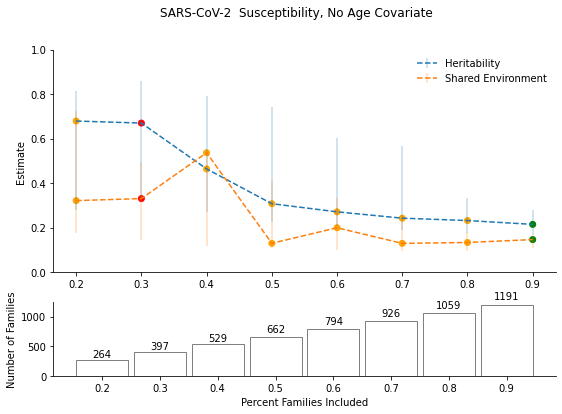

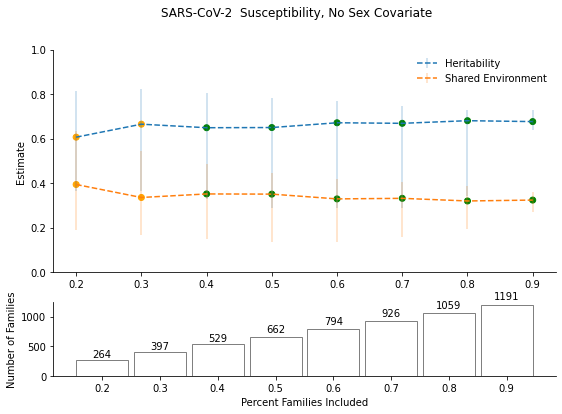

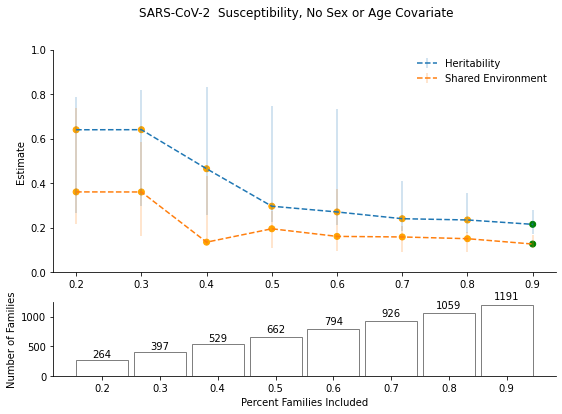

In [26]:
#Graph days hospitalized
graph_percent_fam(solar_df, "covid", "covid")
graph_percent_fam(solar_rev_df, "covid", "covid_noage")
graph_percent_fam(solar_rev_df, "covid", "covid_nosex")
graph_percent_fam(solar_rev_df, "covid", "covid_nosex_noage")
# graph_percent_fam(solar_rev_df, "covid", "female")
# graph_percent_fam(solar_rev_df, "covid", "covid_notfemale")

## Modeled without controlling for sex and age

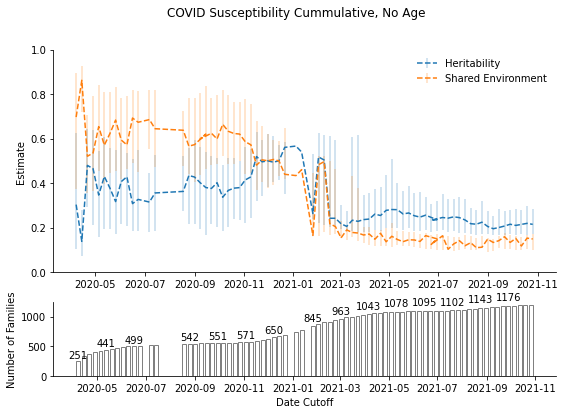

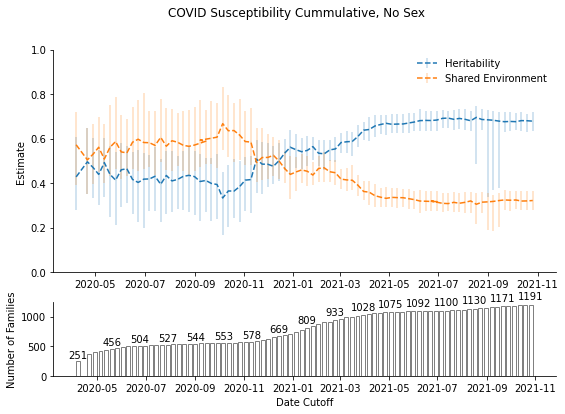

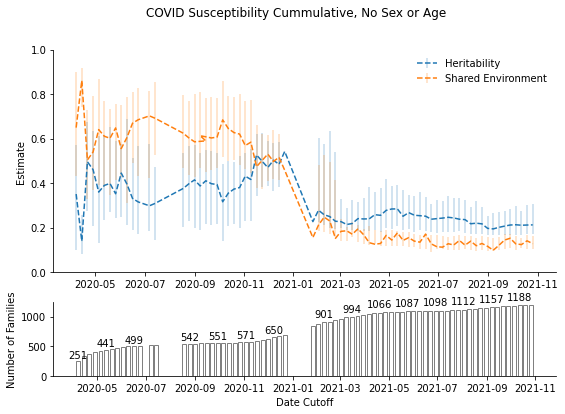

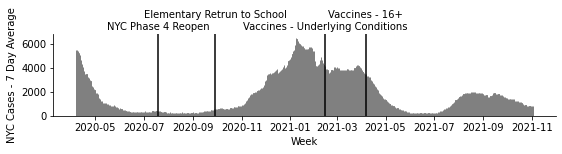

In [27]:
#Minimimum of 50 converged runs


#Partition by phenotype
df_holder = solar_rev_df[ ( solar_rev_df["trait"].str.contains( "covid_cswitch_weekly" ) == True ) &
                        ( solar_rev_df["directory"] == "cummulative_classswitch_noage")
                        ].copy()


df_holder = df_holder[ df_holder["num_converged"].astype(int) > 50 ]


#Pull date cases/controls are included through from phenotype name
df_holder["date"] = df_holder["trait"].apply( pull_date_window )

#sort by the number of families 
df_holder.sort_values(by="num_families",inplace=True)

#get graph
fig = create_graph(df_holder,"date","COVID Susceptibility Cummulative, No Age", remove_scatter_markers = True)

##################


#Partition by phenotype
df_holder = solar_rev_df[ ( solar_rev_df["trait"].str.contains( "covid_cswitch_weekly" ) == True ) &
                        ( solar_rev_df["directory"] == "cummulative_classswitch_nosex")
                        ].copy()



#Pull date cases/controls are included through from phenotype name
df_holder["date"] = df_holder["trait"].apply( pull_date_window )

#sort by the number of families 
df_holder.sort_values(by="num_families",inplace=True)

#get graph
fig = create_graph(df_holder,"date","COVID Susceptibility Cummulative, No Sex", remove_scatter_markers = True)

##################

#Partition by phenotype
df_holder = solar_rev_df[ ( solar_rev_df["trait"].str.contains( "covid_cswitch_weekly" ) == True ) &
                        ( solar_rev_df["directory"] == "cummulative_classswitch_nosex_noage")
                        ].copy()

# print(len(df_holder))
df_holder = df_holder[ df_holder["num_converged"].astype(int) > 50 ]

#Pull date cases/controls are included through from phenotype name
df_holder["date"] = df_holder["trait"].apply( pull_date_window )

#sort by the number of families 
df_holder.sort_values(by="num_families",inplace=True)

#get graph
fig = create_graph(df_holder,"date","COVID Susceptibility Cummulative, No Sex or Age", remove_scatter_markers = True)


##################

#Used in manuscript
fig, axs= plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(9, 1.5)

x = nyc_case_df[ (nyc_case_df["date_cln"] >= weeks[0]) &
                        (nyc_case_df["date_cln"] <= weeks[-1] + timedelta(days=7))
                        ]["date_cln"]

y = nyc_case_df[ (nyc_case_df["date_cln"] >= weeks[0]) &
                        (nyc_case_df["date_cln"] <= weeks[-1] + timedelta(days=7))
                        ]["ALL_CASE_COUNT_7DAY_AVG"]


adm_plt = axs.bar(x,y, width=0.1, color="white",edgecolor='grey')


axs.set_xlabel("Week")
axs.set_ylabel("NYC Cases - 7 Day Average")


sns.despine()




#Phase 4 repopen July 19th, 2020
plt.axvline(x = datetime(2020, 7, 19).date(), color = 'black', label = 'NYC Phase 4 Reopen')
plt.text(datetime(2020, 7, 19).date(), max(y)+ 500, 'NYC Phase 4 Reopen', ha='center', va='bottom')

#Elementary kids return to school September 29, 2020
plt.axvline(x = datetime(2020, 9, 29).date(), color = 'black', label = 'Elementary Return to School')
plt.text(datetime(2020, 9, 29).date(), max(y)+ 1500, 'Elementary Retrun to School', ha='center', va='bottom')


# plt.axvline(x=datetime(2020, 12, 14).date(), color='black')
# plt.text(datetime(2020, 12, 14).date(), max(y)+ 500, '1st vaccination in NYC', ha='center', va='bottom')

plt.axvline(x=datetime(2021, 2, 14).date(), color='black')
plt.text(datetime(2021, 2, 14).date(), max(y)+ 500, 'Vaccines - Underlying Conditions', ha='center', va='bottom')

plt.axvline(x=datetime(2021, 4, 6).date(), color='black')
plt.text(datetime(2021, 4, 6).date(), max(y)+ 1500, 'Vaccines - 16+', ha='center', va='bottom')

plt.show()





## Get reporting estimates

In [28]:
trait_maxposa_df =solar_df[solar_df["model"] == "ACE_h2o"].groupby(["trait"]).\
agg({ "posa":"max"}).reset_index()

top_posa_df = pd.merge(trait_maxposa_df, solar_df, how='left', left_on=['trait','posa'], right_on = ['trait','posa'])

#Limit to those that aren't cummulative or weekly
top_posa_df = top_posa_df[ ~top_posa_df["trait"].str.contains("window|weekly",regex=True )]
reporting_cols = ["trait","model","estimate","estimate_lower","estimate_upper","posa","num_converged","num_significant","num_families"]

In [29]:
models = ["ACE_h2o", "ACE_Shared_Env"]
best_est_list = []
lowqual_ests = []
missing_ests = []

for pheno in phenos:
    for model in models:
        # First get above 80% posas
        holder_df = solar_df[(solar_df["trait"] == pheno) &
                             (solar_df["model"] == model) &
                             (solar_df["posa"] > 0.8)].sort_values(by="num_families")

        # If we have no estimate with a posa over 0.8, use highest estimate we have
        if len(holder_df) == 0:
            holder_df = top_posa_df[(top_posa_df["trait"] == pheno) &
                                    (top_posa_df["model"] == model)]

        else:
            # Else pick the estimate with posa above 0.3 with fewest number of families to limit ascertainment bias
            holder_df = holder_df[holder_df["num_families"] == holder_df["num_families"].min()]

        if len(holder_df) > 0:
            best_est_list.append(holder_df)

        else:
            missing_ests.append((pheno, model))

best_est_dfs = pd.concat(best_est_list)
best_est_dfs["total_samp"] = best_est_dfs["trait"].map(pheno2sampsize)

In [30]:
#Lowest and highest cummulative estimates
cswitch_high_ace = solar_df[ (solar_df["trait"].str.contains("cswitch") & (solar_df["model"] == "ACE_h2o")) ]["estimate"].max()
cswitch_high_ace_trait = solar_df[ solar_df["estimate"] == cswitch_high_ace]["trait"]

cswitch_low_ace = solar_df[ (solar_df["trait"].str.contains("cswitch") & (solar_df["model"] == "ACE_h2o")) ]["estimate"].min()
cswitch_low_ace_trait = solar_df[ solar_df["estimate"] == cswitch_low_ace]["trait"]


In [31]:
solar_df[ solar_df["trait"] == cswitch_low_ace_trait.values[0]]

,trait,ethnicity,num_families,model,estimate,estimate_lower,estimate_upper,solarerr,solarpval,num_attempts,num_converged,num_significant,posa,file,directory,model_clean
632,covid_cswitch_weekly_10_06_2020,ALL,553,AE,0.37361,0.271401,0.526436,0.188234,0.012041,200,185,168,0.908108,ZIHAR_solar_strap_results.csv,cummulative_classswitch,AE
633,covid_cswitch_weekly_10_06_2020,ALL,553,ACE_h2o,0.328873,0.197523,0.458511,0.323686,0.000332,200,196,195,0.994898,ZIHAR_solar_strap_results.csv,cummulative_classswitch,Heritability
634,covid_cswitch_weekly_10_06_2020,ALL,553,ACE_Shared_Env,0.671127,0.541489,0.802477,0.323686,0.0,200,196,195,0.994898,ZIHAR_solar_strap_results.csv,cummulative_classswitch,Shared Environment


In [32]:
solar_df[ solar_df["trait"] == cswitch_high_ace_trait.values[0]]

,trait,ethnicity,num_families,model,estimate,estimate_lower,estimate_upper,solarerr,solarpval,num_attempts,num_converged,num_significant,posa,file,directory,model_clean
578,covid_cswitch_weekly_08_17_2021,ALL,1130,AE,0.516687,0.429742,0.647434,0.051444,0.0,200,194,194,1.0,JHNTP_solar_strap_results.csv,cummulative_classswitch,AE
579,covid_cswitch_weekly_08_17_2021,ALL,1130,ACE_h2o,0.697004,0.634759,0.737944,0.050161,0.0,200,195,195,1.0,JHNTP_solar_strap_results.csv,cummulative_classswitch,Heritability
580,covid_cswitch_weekly_08_17_2021,ALL,1130,ACE_Shared_Env,0.302996,0.245423,0.352153,0.050161,0.0,200,195,195,1.0,JHNTP_solar_strap_results.csv,cummulative_classswitch,Shared Environment


In [33]:
best_est_dfs

,trait,ethnicity,num_families,model,estimate,estimate_lower,estimate_upper,solarerr,solarpval,num_attempts,num_converged,num_significant,posa,file,directory,model_clean,total_samp
723,covid,ALL,529,ACE_h2o,0.649664,0.330907,0.79607,0.07632,0.000022,200,190,160,0.842105,V4I8A_solar_strap_results.csv,covid,Heritability,1324
724,covid,ALL,529,ACE_Shared_Env,0.350336,0.151995,0.507414,0.07632,0.000008,200,190,160,0.842105,V4I8A_solar_strap_results.csv,covid,Shared Environment,1324
436,covid_noproband,ALL,2838,ACE_h2o,0.515058,0.346556,0.636042,0.117858,0.000006,200,74,59,0.797297,KTC0B_solar_strap_results.csv,covid,Heritability,5676
437,covid_noproband,ALL,2838,ACE_Shared_Env,0.172115,0.113182,0.255914,0.068435,0.005036,200,74,59,0.797297,KTC0B_solar_strap_results.csv,covid,Shared Environment,5676
405,days_hosp,ALL,142,ACE_h2o,0.408055,0.333555,0.569962,0.183628,0.014023,200,200,179,0.895,Q81YQ_solar_strap_results.csv,days_hosp,Heritability,158
406,days_hosp,ALL,142,ACE_Shared_Env,0.32742,0.238339,0.383142,0.111908,0.003037,200,200,179,0.895,Q81YQ_solar_strap_results.csv,days_hosp,Shared Environment,158
682,hosp_stat,ALL,92,ACE_h2o,0.548847,0.511175,0.573305,0.227211,0.022562,200,188,6,0.031915,LERC1_solar_strap_results.csv,hosp_stat,Heritability,115
683,hosp_stat,ALL,92,ACE_Shared_Env,0.451153,0.426695,0.488825,0.227211,0.039168,200,188,6,0.031915,LERC1_solar_strap_results.csv,hosp_stat,Shared Environment,115
684,hosp_stat_nopro,ALL,142,ACE_h2o,0.6101,0.521805,0.666328,0.186906,0.003139,200,198,87,0.439394,HD20V_solar_strap_results.csv,hosp_stat,Heritability,158
685,hosp_stat_nopro,ALL,142,ACE_Shared_Env,0.3899,0.333672,0.478195,0.186906,0.026714,200,198,87,0.439394,HD20V_solar_strap_results.csv,hosp_stat,Shared Environment,158
